In [39]:
import os
import cv2
from SegTracker import SegTracker
from model_args import aot_args,sam_args,segtracker_args
from PIL import Image
from aot_tracker import _palette
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import gc

def create_output_dir(output_dir):
    """
    创建给定路径的目录，如果它尚不存在的话。

    参数:
    output_dir (str): 待创建或检查的输出目录路径

    返回:
    None
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"创建目录: {output_dir}")
    else:
        # print(f"目录 {output_dir} 已经存在")
        pass

def save_prediction(pred_mask,output_dir,file_name):
    create_output_dir(output_dir)
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask.save(os.path.join(output_dir,file_name))
def colorize_mask(pred_mask):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask = save_mask.convert(mode='RGB')
    return np.array(save_mask)
def draw_mask(img, mask, alpha=0.7, id_countour=False):
    img_mask = np.zeros_like(img)
    img_mask = img
    if id_countour:
        # very slow ~ 1s per image
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids!=0]

        for id in obj_ids:
            # Overlay color on  binary mask
            if id <= 255:
                color = _palette[id*3:id*3+3]
            else:
                color = [0,0,0]
            foreground = img * (1-alpha) + np.ones_like(img) * alpha * np.array(color)
            binary_mask = (mask == id)

            # Compose image
            img_mask[binary_mask] = foreground[binary_mask]

            countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
            img_mask[countours, :] = 0
    else:
        binary_mask = (mask!=0)
        countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
        foreground = img*(1-alpha)+colorize_mask(mask)*alpha
        img_mask[binary_mask] = foreground[binary_mask]
        img_mask[countours,:] = 0

    return img_mask.astype(img.dtype)

### Set parameters for input and output

In [40]:
video_name = 'cars'
# video_name = 'cell'
# video_name = '240516-02'
# video_name = '240529_1'
# video_name = "423937009-1-208" # cups
io_args = {
    'input_video': f'./assets/{video_name}.mp4',
    'output_mask_dir': f'./assets/{video_name}_masks_with_vit_matte', # save pred masks
    'output_video': f'./assets/{video_name}_seg.mp4', # mask+frame vizualization, mp4 or avi, else the same as input video
    'output_gif': f'./assets/{video_name}_seg.gif', # mask visualization
}

### Tuning Grounding-DINO and SAM on the First Frame for Good Initialization

In [41]:
# init vit matte
import sys
import os

matte_anything_path = "/home/fengkaige/codespace/Matte-Anything/"
os.chdir(matte_anything_path)
sys.path.append("./")

# from matte_anything import init_vitmatte


from detectron2.config import LazyConfig, instantiate
from detectron2.checkpoint import DetectionCheckpointer


def init_vitmatte(model_type):
    """
    Initialize the vitmatte with model_type in ['vit_s', 'vit_b']
    """
    cfg = LazyConfig.load(vitmatte_config[model_type])
    vitmatte = instantiate(cfg.model)
    vitmatte.to(device)
    vitmatte.eval()
    DetectionCheckpointer(vitmatte).load(vitmatte_models[model_type])

    return vitmatte


def generate_trimap(mask, erode_kernel_size=10, dilate_kernel_size=10):
    erode_kernel = np.ones((erode_kernel_size, erode_kernel_size), np.uint8)
    dilate_kernel = np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8)
    eroded = cv2.erode(mask, erode_kernel, iterations=5)
    dilated = cv2.dilate(mask, dilate_kernel, iterations=5)
    trimap = np.zeros_like(mask)
    trimap[dilated == 255] = 128
    trimap[eroded == 255] = 255
    return trimap


def generate_checkerboard_image(height, width, num_squares):
    num_squares_h = num_squares
    square_size_h = height // num_squares_h
    square_size_w = square_size_h
    num_squares_w = width // square_size_w

    new_height = num_squares_h * square_size_h
    new_width = num_squares_w * square_size_w
    image = np.zeros((new_height, new_width), dtype=np.uint8)

    for i in range(num_squares_h):
        for j in range(num_squares_w):
            start_x = j * square_size_w
            start_y = i * square_size_h
            color = 255 if (i + j) % 2 == 0 else 200
            image[
                start_y : start_y + square_size_h, start_x : start_x + square_size_w
            ] = color

    image = cv2.resize(image, (width, height))
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    return image


def run_vit_matte(input_x, masks):

    ### TODO !!!!!!! mask -> trimap
    """
    masks
        shape : (1, 1, 544, 890)
        dtype : bool
    """
    mask = masks.astype(np.uint8) * 255
    # mask = masks
    erode_kernel_size = 1
    dilate_kernel_size = 1
    trimap = generate_trimap(mask, erode_kernel_size, dilate_kernel_size).astype(
        np.float32
    )
    # return trimap
    trimap[trimap == 128] = 0.5
    trimap[trimap == 255] = 1

    # Vit Matte调用
    """
        input_x
            shape : (544, 890, 3)
            dtype : uint8
            type : numpy.ndarray
        trimap
            shape : (544, 890)
            dtype : float32
            max : 0.5
            min : 0.0
            type : numpy.ndarray
    """
    input = {
        "image": torch.from_numpy(input_x).permute(2, 0, 1).unsqueeze(0)
        / 255,  # norm to [0, 1]
        "trimap": torch.from_numpy(trimap).unsqueeze(0).unsqueeze(0),
    }
    # import pdb; pdb.set_trace()
    torch.cuda.empty_cache()
    alpha = vitmatte(input)["phas"].flatten(0, 2)
    alpha = alpha.detach().cpu().numpy()

    return alpha

    # # get a green background
    # background = generate_checkerboard_image(input_x.shape[0], input_x.shape[1], 8)

    # # calculate foreground with alpha blending
    # foreground_alpha = input_x * np.expand_dims(alpha, axis=2).repeat(3,2)/255 + background * (1 - np.expand_dims(alpha, axis=2).repeat(3,2))/255

    # return foreground_alpha
    # background = generate_checkerboard_image(input_x.shape[0], input_x.shape[1], 8)

    # # calculate foreground with mask
    # foreground_mask = input_x * np.expand_dims(mask/255, axis=2).repeat(3,2)/255 + background * (1 - np.expand_dims(mask/255, axis=2).repeat(3,2))/255
    # return foreground_mask


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

vitmatte_models = {
    "vit_b": "./pretrained/ViTMatte_B_DIS.pth",
}

vitmatte_config = {
    "vit_b": "./configs/matte_anything.py",
}

vitmatte_model = "vit_b"
vitmatte = init_vitmatte(vitmatte_model)

matte_anything_path = "//home/fengkaige/codespace/Segment-and-Track-Anything"
os.chdir(matte_anything_path)
sys.path.append("./")

## 直接读取图片运行

In [42]:
davis_2017_val_txt = (
    "/home/fengkaige/codespace/XMem/DAVIS/2017/trainval/ImageSets/2017/val.txt"
)
davis_2017_val_case_img_base_path = (
    "/home/fengkaige/codespace/XMem/DAVIS/2017/trainval/JPEGImages/480p/"
)
davis_2017_val_case_annotation_base_path = "/home/fengkaige/codespace/XMem/DAVIS/2017/trainval/Annotations/480p/"
davis_2017_val_case_annotation_output_base_path = "/home/fengkaige/codespace/output_vit/d17"

In [43]:
from typing import List


def read_file(filename):
    """读取文本文件"""
    try:
        with open(filename, 'r') as file:
            content = file.read()
    except FileNotFoundError:
        print("文件未找到，请检查文件名或路径。")
        return None
    except Exception as e:
        print(f"读取文件时发生错误：{e}")
        return None

    return content

davis_2017_val = read_file(davis_2017_val_txt)
davis_2017_val_cases: List[str]   = davis_2017_val.split("\n")
davis_2017_val_case_num = len(davis_2017_val_cases)

# Run One Case

## Test Read img and annotation

0 00000.jpg
img.shape: (480, 910, 3)


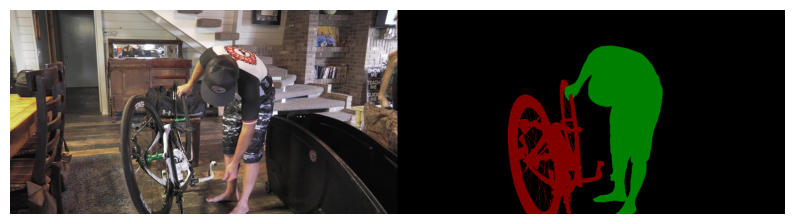

In [44]:
case_name = davis_2017_val_cases[0]
case_img_folder = os.path.join(davis_2017_val_case_img_base_path, case_name)
case_annotation_folder = os.path.join(
    davis_2017_val_case_annotation_base_path, case_name
)

for frame_idx, img_name in enumerate(sorted(os.listdir(case_img_folder))):
    print(frame_idx, img_name)
    # Read img
    img_path = os.path.join(case_img_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print("img.shape:", img.shape)
    # Read annotation
    annotation_frame_path = os.path.join(
        case_annotation_folder, "{:05}.png".format(img_name.split(".")[0])
    )
    if os.path.exists(annotation_frame_path):
        annotated_frame = cv2.imread(annotation_frame_path)
        annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
        img = np.concatenate((img, annotated_frame), axis=1)

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    # plt.imshow(colorize_mask(annotated_frame))
    plt.imshow(img)
    plt.show()
    break

## Test Run One Folder of image seq

In [45]:
def convert_rgb_to_mask(rgb_image):
    # 获取图片的高度和宽度
    h, w, _ = rgb_image.shape

    # 创建一个空的mask
    mask = np.zeros((h, w), dtype=np.int32)

    # 创建颜色到对象ID的映射
    unique_colors = np.unique(rgb_image.reshape(-1, 3), axis=0)
    color_to_id = {tuple(color): idx for idx, color in enumerate(unique_colors)}

    # 遍历每个像素，将RGB颜色转换为对象ID
    for color, obj_id in color_to_id.items():
        mask[(rgb_image == color).all(axis=2)] = obj_id

    return mask


def convert_mask_to_rgb(mask, color_map=None):

    # 获取图片的高度和宽度
    h, w = mask.shape

    # 如果没有提供颜色映射，则自动生成
    if color_map is None:
        unique_ids = np.unique(mask)
        color_map = {
            obj_id: tuple(np.random.randint(0, 256, size=3)) for obj_id in unique_ids
        }

    # 创建一个空的RGB图像
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)

    # 遍历每个对象ID，将其转换为对应的颜色
    for obj_id, color in color_map.items():
        rgb_image[mask == obj_id] = color

    return rgb_image, color_map

In [46]:
def show_pred_mask(pred_mask):
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(colorize_mask(pred_mask))
    plt.imshow(pred_mask)
    plt.show()

def compute_mean_index(t):
    import torch
    t_tmp = torch.Tensor(t)
    # 找到所有值为 1 的点的索引
    indices = torch.nonzero(t_tmp == 1)

    # 计算两个维度的索引的平均值
    mean_indices = indices.float().mean(dim=0)

    print(f"平均索引: (dim 0, dim 1) = ({mean_indices[0].item()}, {mean_indices[1].item()})")



In [47]:
def rearrange_ids(matrix):
    # 获取唯一的 id，排除 0
    unique_ids = np.unique(matrix)
    unique_ids = unique_ids[unique_ids != 0]

    # 存储 id 及其索引的平均值
    id_mean_positions = {}

    # 计算每个 id 在矩阵中的索引平均值
    for id_val in unique_ids:
        indices = np.argwhere(matrix == id_val)
        mean_position = indices.mean(axis=0)
        id_mean_positions[id_val] = mean_position

    # 根据平均值对 id 进行排序
    sorted_ids = sorted(
        id_mean_positions.keys(), key=lambda id_val: id_mean_positions[id_val][1]
    )

    # 创建一个新的矩阵来存储重新排列的 id
    sorted_matrix = np.copy(matrix)

    # 创建一个映射表，将旧 id 映射到新 id
    id_mapping = {old_id: new_id for new_id, old_id in enumerate(sorted_ids, start=1)}

    # 使用映射表重新排列 id，保持 0 不变
    for old_id, new_id in id_mapping.items():
        sorted_matrix[matrix == old_id] = new_id

    return sorted_matrix

def rearrange_pred_mask(pred_mask, _debug = False):
    """
    重排 id( id 是矩阵数据点的数值), 通过 mask 的位置
    为什么需要重排：因为通过 SAM 得到的 id 和 davis 数据集评价程序的 id 顺序不一样
    """
    # 重排前
    if _debug:
        print("before rearrange:")
        max_label = int(pred_mask.max())
        for i in range(1, max_label + 1):
            compute_mean_index(pred_mask == i)
    # 重排
    track_mask_rearrange = rearrange_ids(pred_mask)
    # 重排后
    if _debug:
        max_label = int(track_mask_rearrange.max())
        print("after rearrange:")
        for i in range(1, max_label + 1):
            compute_mean_index(track_mask_rearrange == i)
    return track_mask_rearrange

## Run One Case of Davis 2017

In [55]:
# choose good parameters in sam_args based on the first frame segmentation result
# other arguments can be modified in model_args.py
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp
sam_args["generator_args"] = {
    "points_per_side": 30,
    "pred_iou_thresh": 0.8,
    "stability_score_thresh": 0.9,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 200,
}

### Generate Results for the Whole Video
# For every sam_gap frames, we use SAM to find new objects and add them for tracking
# larger sam_gap is faster but may not spot new objects in time
segtracker_args = {
    "sam_gap": 49,  # the interval to run sam to segment new objects
    "min_area": 200,  # minimal mask area to add a new mask as a new object
    "max_obj_num": 255,  # maximal object number to track in a video
    "min_new_obj_iou": 0.8,  # the area of a new object in the background should > 80%
}


def run_one_case(
    case_img_folder, case_annotation_folder, case_output_folder, _debug=False
):
    print("+" * 20, f"start case {case_img_folder}", "+"*20)
    torch.cuda.empty_cache()
    gc.collect()
    frame_idx = 0
    segtracker = SegTracker(segtracker_args, sam_args, aot_args)

    def ensure_dir(path):
        dirname = os.path.dirname(path)
        if not os.path.exists(dirname):
            os.makedirs(dirname)

    with torch.cuda.amp.autocast():
        for frame_idx, img_name in enumerate(sorted(os.listdir(case_img_folder))):
            print(frame_idx, img_name)
            # Read img
            img_path = os.path.join(case_img_folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if _debug:
                print("img.shape:", img.shape)
            # Read annotation
            annotation_frame_path = os.path.join(
                case_annotation_folder, "{:05}.png".format(img_name.split(".")[0])
            )
            if os.path.exists(annotation_frame_path):
                annotated_frame = cv2.imread(annotation_frame_path)
                annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
                if _debug:
                    print("annotated_frame.shape:", annotated_frame.shape)
            else:
                raise FileNotFoundError(
                    "Annotation file {} not found".format(annotation_frame_path)
                )

            if frame_idx == 0:
                # 第一帧：数据集直接从annotation文件中获取预测mask
                torch.cuda.empty_cache()
                gc.collect()
                pred_mask = convert_rgb_to_mask(annotated_frame)
                segtracker.add_reference(img, pred_mask)
            else:
                """
                    frame:
                        type: numpy.ndarray
                        shape: (1080, 1920, 3)
                        dtype: uint8
                """
                track_mask = segtracker.track(img, update_memory=True)
                '''
                pred_mask
                    type: numpy.ndarray
                    shape : (1080, 1920)
                    dtype : uint8
                    min, max: 0, 1
                '''
                # mask -> trimap --(vit-matte)-->  alphe
                track_mask = rearrange_pred_mask(track_mask)
                ###### 循环的方式
                max_label = int(track_mask.max())
                pred_mask = np.zeros_like(track_mask, dtype=np.uint8)
                for i in range(1, max_label + 1):
                    vit_alpha = run_vit_matte(img, track_mask == i)
                    ###### 下面的处理会多出来 idx
                    # vit_alpha[vit_alpha > 0.5] = i
                    # vit_alpha[vit_alpha < 0.5] = 0
                    # pred_mask += vit_alpha.astype(np.uint8)
                    ######
                    pred_mask[vit_alpha > 0.5] = i
                    if _debug:
                        print("show every id's pred_mask")
                        show_pred_mask(pred_mask) # Debug

                ###### 非循环的方式
                # # track_mask = pred_mask # test 直接给第一帧的输入 trimap
                # pred_mask = np.zeros_like(track_mask, dtype=np.uint8)
                # vit_alpha = run_vit_matte(img, track_mask == 1)
                # vit_alpha[vit_alpha > 0.5] = 1
                # vit_alpha[vit_alpha < 0.5] = 0
                # pred_mask += vit_alpha.astype(np.uint8)
                # vit_alpha = run_vit_matte(img, track_mask == 2)
                # vit_alpha[vit_alpha > 0.5] = 2
                # vit_alpha[vit_alpha < 0.5] = 0
                # pred_mask += vit_alpha.astype(np.uint8)

            # plt.figure(figsize=(10, 10))
            # plt.axis("off")
            # plt.imshow(colorize_mask(pred_mask))
            # plt.imshow(pred_mask)
            # plt.show()

            output_img_path = os.path.join(case_output_folder, "{:05}.png".format(img_name.split(".")[0]))
            # print("save annation to {}".format(output_img_path))
            # ensure_dir(output_img_path)
            # # cv2.imwrite(output_img_path, pred_mask)
            # cv2.imwrite(output_img_path, colorize_mask(pred_mask))

            ensure_dir(output_img_path)
            print("save annation to {}".format(output_img_path))
            save_prediction(pred_mask, case_output_folder, "{:05}.png".format(img_name.split(".")[0]))

            # For Debug
            if _debug:
                print("Debug, exit after frame 1")
                if frame_idx == 1:
                    break
    print("-" * 20, f"finish case {case_img_folder}", "-" * 20)

In [56]:
matte_anything_path = "//home/fengkaige/codespace/Segment-and-Track-Anything"
os.chdir(matte_anything_path)
sys.path.append("./")

_debug = False
case_name = davis_2017_val_cases[0]
case_img_folder = os.path.join(davis_2017_val_case_img_base_path, case_name)
case_output_folder = os.path.join(
    davis_2017_val_case_annotation_output_base_path, case_name
)
case_annotation_folder = os.path.join(
    davis_2017_val_case_annotation_base_path, case_name
)
run_one_case(case_img_folder, case_annotation_folder, case_output_folder, _debug)

++++++++++++++++++++ start case /home/fengkaige/codespace/XMem/DAVIS/2017/trainval/JPEGImages/480p/bike-packing ++++++++++++++++++++
final text_encoder_type: /home/fengkaige/codespace/Segment-and-Track-Anything/hugco/bert-base-uncased
Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized
0 00000.jpg
save annation to /home/fengkaige/codespace/output_vit/d17/bike-packing/00000.png
1 00001.jpg
save annation to /home/fengkaige/codespace/output_vit/d17/bike-packing/00001.png
2 00002.jpg
save annation to /home/fengkaige/codespace/output_vit/d17/bike-packing/00002.png
3 00003.jpg
save annation to /home/fengkaige/codespace/output_vit/d17/bike-packing/00003.png
4 00004.jpg
save annation to /home/fengkaige/codespace/output_vit/d17/bike-packing/00004.png
5 00005.jpg
save annation to /home/fengkaige/codespace/output_vit/d17/bike-packing/00005.png
6 00006.jpg


## Run All Case of Davis 2017

In [57]:
matte_anything_path = "//home/fengkaige/codespace/Segment-and-Track-Anything"
os.chdir(matte_anything_path)
sys.path.append("./")

_debug = False
case_name = davis_2017_val_cases[0]
for case_name in davis_2017_val_cases:
    case_img_folder = os.path.join(davis_2017_val_case_img_base_path, case_name)
    case_output_folder = os.path.join(
        davis_2017_val_case_annotation_output_base_path, case_name
    )
    case_annotation_folder = os.path.join(
        davis_2017_val_case_annotation_base_path, case_name
    )
    run_one_case(case_img_folder, case_annotation_folder, case_output_folder, _debug)

"""
TODO
问题 1. 文件夹读取问题
问题 2. 部分id 依然存在问题
更换为进度条
"""

++++++++++++++++++++ start case /home/fengkaige/codespace/XMem/DAVIS/2017/trainval/JPEGImages/480p/bike-packing ++++++++++++++++++++
final text_encoder_type: /home/fengkaige/codespace/Segment-and-Track-Anything/hugco/bert-base-uncased
Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized
0 00000.jpg
save annation to /home/fengkaige/codespace/output_vit/d17/bike-packing/00000.png
1 00001.jpg
save annation to /home/fengkaige/codespace/output_vit/d17/bike-packing/00001.png
2 00002.jpg
save annation to /home/fengkaige/codespace/output_vit/d17/bike-packing/00002.png
3 00003.jpg
save annation to /home/fengkaige/codespace/output_vit/d17/bike-packing/00003.png
4 00004.jpg
save annation to /home/fengkaige/codespace/output_vit/d17/bike-packing/00004.png
5 00005.jpg
save annation to /home/fengkaige/codespace/output_vit/d17/bike-packing/00005.png
6 00006.jpg


error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
# from tqdm import tqdm
        for seq in tqdm(list(self.dataset.get_sequences())):
            ..........
            # Show progress
            if debug:
                sys.stdout.write(seq + "\n")
                sys.stdout.flush()

In [ ]:
case_name = davis_2017_val_cases[0]
case_img_folder = os.path.join(davis_2017_val_case_img_base_path, case_name)
case_annotation_folder = os.path.join(
    davis_2017_val_case_annotation_base_path, case_name
)
# choose good parameters in sam_args based on the first frame segmentation result
# other arguments can be modified in model_args.py
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp
sam_args["generator_args"] = {
    "points_per_side": 30,
    "pred_iou_thresh": 0.8,
    "stability_score_thresh": 0.9,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 200,
}

### Generate Results for the Whole Video
# For every sam_gap frames, we use SAM to find new objects and add them for tracking
# larger sam_gap is faster but may not spot new objects in time
segtracker_args = {
    "sam_gap": 49,  # the interval to run sam to segment new objects
    "min_area": 200,  # minimal mask area to add a new mask as a new object
    "max_obj_num": 255,  # maximal object number to track in a video
    "min_new_obj_iou": 0.8,  # the area of a new object in the background should > 80%
}

matte_anything_path = "//home/fengkaige/codespace/Segment-and-Track-Anything"
os.chdir(matte_anything_path)
sys.path.append("./")


torch.cuda.empty_cache()
gc.collect()
frame_idx = 0
segtracker = SegTracker(segtracker_args, sam_args, aot_args)

with torch.cuda.amp.autocast():
    for frame_idx, img_name in enumerate(sorted(os.listdir(case_img_folder))):
        print(frame_idx, img_name)
        # Read img
        img_path = os.path.join(case_img_folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print("img.shape:", img.shape)
        # Read annotation
        annotation_frame_path = os.path.join(
            case_annotation_folder, "{:05}.png".format(img_name.split(".")[0])
        )
        if os.path.exists(annotation_frame_path):
            annotated_frame = cv2.imread(annotation_frame_path)
            annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
            print("annotated_frame.shape:", annotated_frame.shape)
        else:
            raise FileNotFoundError(
                "Annotation file {} not found".format(annotation_frame_path)
            )

        if frame_idx == 0:
            # 第一帧：数据集直接从annotation文件中获取预测mask
            torch.cuda.empty_cache()
            mask_h_w = convert_rgb_to_mask(annotated_frame)

            # make_h_w = annotated_frame.sum(axis=-1)

            ###### annotation shape(h, w, obj_num) -> mask shape(h, w)
            # make_h_w = np.zeros(annotated_frame.shape[:2], dtype=np.uint8)
            # for obj_idx in range(1, annotated_frame.shape[2]):
            #     obj_mask = annotated_frame[:, :, obj_idx]
            #     obj_mask[obj_mask > 0] = obj_idx
            #     make_h_w += obj_mask

            ###### annotation -> mask
            # make_h_w = np.zeros(annotated_frame.shape[:2], dtype=np.uint8)
            # make_h_w[annotated_frame[:, :, 0] != 0] = 0
            # make_h_w[annotated_frame[:, :, 1] != 0] = 1
            # make_h_w[annotated_frame[:, :, 2] != 0] = 2

            # annotated_frame[annotated_frame > 0.5] = 1
            # annotated_frame[annotated_frame < 0.5] = 0

            # segtracker.add_reference(img, make_h_w)

            pred_mask = mask_h_w
        else:
            """
                frame:
                    type: numpy.ndarray
                    shape: (1080, 1920, 3)
                    dtype: uint8
            """
            pred_mask = segtracker.track(img, update_memory=True)
            '''
            pred_mask
                type: numpy.ndarray
                shape : (1080, 1920)
                dtype : uint8
                min, max: 0, 1
            '''
            # mask -> trimap --(vit-matte)-->  alphe
            # TODO
            # output = run_vit_matte(frame, pred_mask)
            # pred_mask = output

        plt.figure(figsize=(10, 10))
        plt.axis("off")
        # plt.imshow(colorize_mask(annotated_frame))
        plt.imshow(pred_mask)
        plt.show()
        if frame_idx == 1:
            break

In [ ]:
case_name = davis_2017_val_cases[0]
case_img_folder = os.path.join(davis_2017_val_case_img_base_path, case_name)
case_annotation_folder = os.path.join(
    davis_2017_val_case_annotation_base_path, case_name
)
# choose good parameters in sam_args based on the first frame segmentation result
# other arguments can be modified in model_args.py
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp
sam_args["generator_args"] = {
    "points_per_side": 30,
    "pred_iou_thresh": 0.8,
    "stability_score_thresh": 0.9,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 200,
}

### Generate Results for the Whole Video
# For every sam_gap frames, we use SAM to find new objects and add them for tracking
# larger sam_gap is faster but may not spot new objects in time
segtracker_args = {
    "sam_gap": 49,  # the interval to run sam to segment new objects
    "min_area": 200,  # minimal mask area to add a new mask as a new object
    "max_obj_num": 255,  # maximal object number to track in a video
    "min_new_obj_iou": 0.8,  # the area of a new object in the background should > 80%
}

matte_anything_path = "//home/fengkaige/codespace/Segment-and-Track-Anything"
os.chdir(matte_anything_path)
sys.path.append("./")


torch.cuda.empty_cache()
gc.collect()
frame_idx = 0
segtracker = SegTracker(segtracker_args, sam_args, aot_args)

with torch.cuda.amp.autocast():
    for frame_idx, img_name in enumerate(sorted(os.listdir(case_img_folder))):
        print(frame_idx, img_name)
        # Read img
        img_path = os.path.join(case_img_folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print("img.shape:", img.shape)
        # Read annotation
        annotation_frame_path = os.path.join(
            case_annotation_folder, "{:05}.png".format(img_name.split(".")[0])
        )
        if os.path.exists(annotation_frame_path):
            annotated_frame = cv2.imread(annotation_frame_path)
            annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
            print("annotated_frame.shape:", annotated_frame.shape)
        else:
            raise FileNotFoundError(
                "Annotation file {} not found".format(annotation_frame_path)
            )

        if frame_idx == 0:
            # 第一帧：数据集直接从annotation文件中获取预测mask
            torch.cuda.empty_cache()



            ###### annotation shape(h, w, obj_num) -> mask shape(h, w)
            # make_h_w = np.zeros(annotated_frame.shape[:2], dtype=np.uint8)
            # for obj_idx in range(1, annotated_frame.shape[2]):
            #     obj_mask = annotated_frame[:, :, obj_idx]
            #     obj_mask[obj_mask > 0] = obj_idx
            #     make_h_w += obj_mask

            ###### annotation -> mask
            # make_h_w = np.zeros(annotated_frame.shape[:2], dtype=np.uint8)
            # make_h_w[annotated_frame[:, :, 0] != 0] = 0
            # make_h_w[annotated_frame[:, :, 1] != 0] = 1
            # make_h_w[annotated_frame[:, :, 2] != 0] = 2

            # annotated_frame[annotated_frame > 0.5] = 1
            # annotated_frame[annotated_frame < 0.5] = 0
            segtracker.add_reference(img, mask_h_w)
            pred_mask = annotated_frame
        else:
            """
                frame:
                    type: numpy.ndarray
                    shape: (1080, 1920, 3)
                    dtype: uint8
            """
            pred_mask = segtracker.track(img, update_memory=True)
            '''
            pred_mask
                type: numpy.ndarray
                shape : (1080, 1920)
                dtype : uint8
                min, max: 0, 1
            '''
            # mask -> trimap --(vit-matte)-->  alphe
            # TODO
            # output = run_vit_matte(frame, pred_mask)
            # pred_mask = output

        plt.figure(figsize=(10, 10))
        plt.axis("off")
        # plt.imshow(colorize_mask(annotated_frame))
        plt.imshow(pred_mask)
        plt.show()
        if frame_idx == 1:
            break

In [ ]:
# choose good parameters in sam_args based on the first frame segmentation result
# other arguments can be modified in model_args.py
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp
sam_args['generator_args'] = {
        'points_per_side': 30,
        'pred_iou_thresh': 0.8,
        'stability_score_thresh': 0.9,
        'crop_n_layers': 1,
        'crop_n_points_downscale_factor': 2,
        'min_mask_region_area': 200,
    }

# Set Text args
'''
parameter:
    grounding_caption: Text prompt to detect objects in key-frames
    box_threshold: threshold for box
    text_threshold: threshold for label(text)
    box_size_threshold: If the size ratio between the box and the frame is larger than the box_size_threshold, the box will be ignored. This is used to filter out large boxes.
    reset_image: reset the image embeddings for SAM
'''
# grounding_caption = ""
# grounding_caption = "car.suv"
# grounding_caption = "door"
# grounding_caption = "girl"
# grounding_caption = "Beverage bottles"
grounding_caption = "human"
# grounding_caption = "cups"
# grounding_caption = "left cups"
box_threshold, text_threshold, box_size_threshold, reset_image = 0.35, 0.5, 0.5, True

cap = cv2.VideoCapture(io_args['input_video'])
frame_idx = 0
segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()


human_img = cv2.imread("./assets/human_seg/606332/00000_img.jpg")
human_trimap = cv2.imread("./assets/human_seg/606332/00000_trimp.png")
frame = human_img

with torch.cuda.amp.autocast():

    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    pred_mask, annotated_frame = segtracker.detect_and_seg(
        frame,
        grounding_caption,
        box_threshold,
        text_threshold,
        box_size_threshold,
    )

    torch.cuda.empty_cache()
    obj_ids = np.unique(pred_mask)
    obj_ids = obj_ids[obj_ids != 0]
    print(
        "processed frame {}, obj_num {}".format(frame_idx, len(obj_ids)), end="\n"
    )

    # Vit Matte
    pred_mask = run_vit_matte(frame, np.array(pred_mask == 2).astype(np.uint8))

    init_res = draw_mask(annotated_frame, pred_mask,id_countour=False)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(init_res)
    plt.show()
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(colorize_mask(pred_mask))
    plt.show()

    del segtracker
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
### Generate Results for the Whole Video
# For every sam_gap frames, we use SAM to find new objects and add them for tracking
# larger sam_gap is faster but may not spot new objects in time
segtracker_args = {
    'sam_gap': 49, # the interval to run sam to segment new objects
    'min_area': 200, # minimal mask area to add a new mask as a new object
    'max_obj_num': 255, # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80%
}


In [ ]:
matte_anything_path = "//home/fengkaige/codespace/Segment-and-Track-Anything"
os.chdir(matte_anything_path)
sys.path.append("./")


# source video to segment
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
# output masks
output_dir = io_args['output_mask_dir']
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
pred_list = []
masked_pred_list = []

torch.cuda.empty_cache()
gc.collect()
sam_gap = segtracker_args['sam_gap']
frame_idx = 0
segtracker = SegTracker(segtracker_args, sam_args, aot_args)
segtracker.restart_tracker()

with torch.cuda.amp.autocast():
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        if frame_idx == 0:
            # 第一帧：通过文字、框选、大小阈值等条件进行目标分割，得到预测mask
            # 并将分割结果作为参考mask添加到跟踪器中
            # pred_mask, _ = segtracker.detect_and_seg_vitmatte(
            #     frame,
            #     grounding_caption,
            #     box_threshold,
            #     text_threshold,
            #     box_size_threshold,
            #     reset_image,
            #     run_vit_matte
            # )
            pred_mask, _ = segtracker.detect_and_seg(
                frame,
                grounding_caption,
                box_threshold,
                text_threshold,
                box_size_threshold,
                reset_image,
            )
            # pred_mask = cv2.imread('./debug/first_frame_mask.png', 0)
            torch.cuda.empty_cache()
            gc.collect()
            segtracker.add_reference(frame, pred_mask)
        elif (frame_idx % sam_gap) == 0:
            # seg_mask, _ = segtracker.detect_and_seg_vitmatte(
            #     frame,
            #     grounding_caption,
            #     box_threshold,
            #     text_threshold,
            #     box_size_threshold,
            #     reset_image,
            #     run_vit_matte,
            # )
            seg_mask, _ = segtracker.detect_and_seg(
                frame,
                grounding_caption,
                box_threshold,
                text_threshold,
                box_size_threshold,
                reset_image,
            )
            save_prediction(seg_mask, './debug/seg_result', str(frame_idx)+'.png')
            torch.cuda.empty_cache()
            gc.collect()
            track_mask = segtracker.track(frame)
            save_prediction(track_mask, './debug/aot_result', str(frame_idx)+'.png')
            # find new objects, and update tracker with new objects
            new_obj_mask = segtracker.find_new_objs(track_mask, seg_mask)
            if np.sum(new_obj_mask > 0) >  frame.shape[0] * frame.shape[1] * 0.4:
                new_obj_mask = np.zeros_like(new_obj_mask)
            save_prediction(new_obj_mask,output_dir,str(frame_idx)+'_new.png')
            pred_mask = track_mask + new_obj_mask
            # segtracker.restart_tracker()
            segtracker.add_reference(frame, pred_mask)
        else:
            """
                frame:
                    type: numpy.ndarray
                    shape: (1080, 1920, 3)
                    dtype: uint8
            """
            pred_mask = segtracker.track(frame,update_memory=True)

            '''
            pred_mask
                type: numpy.ndarray
                shape : (1080, 1920)
                dtype : uint8
                min, max: 0, 1
            '''
            # mask -> trimap --(vit-matte)-->  alphe
            # TODO
            # output = run_vit_matte(frame, pred_mask)
            # pred_mask = output

        torch.cuda.empty_cache()
        gc.collect()

        save_prediction(pred_mask,output_dir,str(frame_idx)+'.png')
        # masked_frame = draw_mask(frame,pred_mask)
        # masked_pred_list.append(masked_frame)
        # plt.imshow(masked_frame)
        # plt.show()

        pred_list.append(pred_mask)

        print("processed frame {}, obj_num {}".format(frame_idx,segtracker.get_obj_num()),end='\r')
        frame_idx += 1
    cap.release()
    print('\nfinished')

### Save results for visualization

In [ ]:
# draw pred mask on frame and save as a video
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if io_args['input_video'][-3:]=='mp4':
    fourcc =  cv2.VideoWriter_fourcc(*"mp4v")
elif io_args['input_video'][-3:] == 'avi':
    fourcc =  cv2.VideoWriter_fourcc(*"MJPG")
    # fourcc = cv2.VideoWriter_fourcc(*"XVID")
else:
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
out = cv2.VideoWriter(io_args['output_video'], fourcc, fps, (width, height))

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    pred_mask = pred_list[frame_idx]
    masked_frame = draw_mask(frame,pred_mask)
    # masked_frame = masked_pred_list[frame_idx]
    masked_frame = cv2.cvtColor(masked_frame,cv2.COLOR_RGB2BGR)
    out.write(masked_frame)
    print('frame {} writed'.format(frame_idx),end='\r')
    frame_idx += 1
out.release()
cap.release()
print("\n{} saved".format(io_args['output_video']))
print('\nfinished')

In [ ]:
# save colorized masks as a gif
imageio.mimsave(io_args['output_gif'],pred_list,fps=fps)
print("{} saved".format(io_args['output_gif']))

In [ ]:
# manually release memory (after cuda out of memory)
del segtracker
torch.cuda.empty_cache()
gc.collect()